In [1]:
import torch
import matplotlib.pyplot as plt

Загружаем датасет

In [2]:
import torchvision.transforms as T
from torchvision.datasets import OxfordIIITPet

dataset = OxfordIIITPet('/home/jupyter/mnt/datasets/pets',download=True,
                        target_types='segmentation')

100%|██████████| 791918971/791918971 [00:28<00:00, 27804301.31it/s]


Extracting /home/jupyter/mnt/datasets/pets/oxford-iiit-pet/images.tar.gz to /home/jupyter/mnt/datasets/pets/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 14015954.76it/s]


Extracting /home/jupyter/mnt/datasets/pets/oxford-iiit-pet/annotations.tar.gz to /home/jupyter/mnt/datasets/pets/oxford-iiit-pet


Проверяем загрузку

In [3]:
dataset

Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: /home/jupyter/mnt/datasets/pets

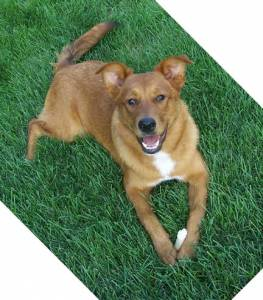

In [4]:
dataset[111][0]

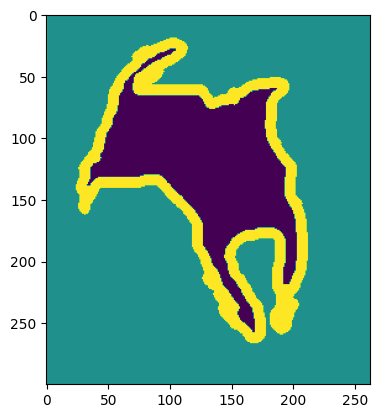

In [5]:
plt.imshow(dataset[111][1])

Задаем трансформацию объектов из датасета, делим на тренировочный и тестовый

In [6]:
transform = T.Compose(
    [
        T.Resize((256, 256)),
        T.ToTensor(),
    ]
)

target_transform = T.Compose(
    [
        T.Resize((256, 256)),
        T.PILToTensor(),
        T.Lambda(lambda x: (x - 1).long())
    ]
)

train_dataset = OxfordIIITPet('/home/jupyter/mnt/datasets/pets', transform=transform,
                              target_transform=target_transform,
                              target_types='segmentation')
valid_dataset = OxfordIIITPet('/home/jupyter/mnt/datasets/pets', transform=transform,
                              split='test', target_transform=target_transform,
                              target_types='segmentation')

Создаем даталоадер

In [7]:
from torch.utils.data import DataLoader, Subset
import numpy as np

np.random.seed(100)
idx = np.random.randint(len(valid_dataset), size=200)

subset = Subset(valid_dataset, idx)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2,
                          pin_memory=True)
valid_loader = DataLoader(subset, batch_size=16, shuffle=False, num_workers=2,
                          pin_memory=True)

Функция для тренировки модели

In [8]:
from tqdm import tqdm

def train(model) -> float:
    model.train()
    train_loss = 0
    total = 0
    correct = 0
    for x, y in tqdm(train_loader, desc='Train'):
        bs = y.size(0)
        x, y = x.to(device), y.squeeze(1).to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

Функция для получения предсказания модели

In [9]:
@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        bs = y.size(0)
        x, y = x.to(device), y.squeeze(1).to(device)
        output = model(x)
        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))
        total_loss += loss.item()
        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

Функция для вывода при обучении графика параметров

In [10]:
from IPython.display import clear_output

def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))
    
    plt.title(title + ' loss')
    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()
    plt.show()
    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()
    plt.show()

Вывод изображений с результатами детекции при обучении модели

In [11]:
import numpy as np
from PIL import Image


@torch.inference_mode()
def visualize(model, batch):
    model.eval()

    xs, ys = batch
    
    to_pil = T.ToPILImage()

    for i, (x, y) in enumerate(zip(xs, ys)):
        prediction = model(x.unsqueeze(0).cuda()).squeeze(0).max(dim=0)[1]

        fig, ax = plt.subplots(1, 3, figsize=(24, 8), facecolor='white')

        ax[0].imshow(to_pil(x))
        ax[1].imshow(to_pil(y.to(torch.uint8)))
        ax[2].imshow(to_pil(prediction.to(torch.uint8)))

        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')

        ax[0].set_title('Original image')
        ax[1].set_title('Segmentation mask')
        ax[2].set_title('Prediction')

        plt.subplots_adjust(wspace=0, hspace=0.1)
        plt.show()

        if i >= 9:
            break

Функция для обучения модели

In [12]:
from time import perf_counter

def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []
    
    start = perf_counter()
    single_pred = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

        visualize(model, next(iter(valid_loader)))
        if valid_accuracy >= 0.88:
            print('Validation accuracy reached 0.88')
            break
    print(f'Total training and evaluation time {perf_counter() - start:.1f}')
    print('accuracy = ', valid_accuracy)
    return model

In [13]:
import torch.nn as nn


def conv_plus_conv(in_channels: int, out_channels: int):
    """
    Makes UNet block
    :param in_channels: input channels
    :param out_channels: output channels
    :return: UNet block
    """
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
        nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
    )

Класс для создания UNet-объектов

In [14]:
import torch
import torch.nn as nn

def up_conv(in_channels, out_channels):
    return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Define the network architecture
        self.down_layer_1 = conv_plus_conv(3, 64)
        self.down_layer_2 = conv_plus_conv(64, 128)
        self.down_layer_3 = conv_plus_conv(128, 256)
        self.down_layer_4 = conv_plus_conv(256, 512)
        self.down_layer_5 = conv_plus_conv(512, 1024)

        self.up_layer_1 = up_conv(1024, 512)
        self.up_conv_1 = conv_plus_conv(1024, 512)
        self.up_layer_2 = up_conv(512, 256)
        self.up_conv_2 = conv_plus_conv(512, 256)
        self.up_layer_3 = up_conv(256, 128)
        self.up_conv_3 = conv_plus_conv(256, 128)
        self.up_layer_4 = up_conv(128, 64)
        self.up_conv_4 = conv_plus_conv(128, 64)
        self.up_layer_5 = nn.Conv2d(64, 3, kernel_size=1)
        
    def forward(self, x):
        # Downsampling/encoding path
        x1 = self.down_layer_1(x)
        x2 = self.down_layer_2(nn.MaxPool2d(2, stride=2)(x1))
        x3 = self.down_layer_3(nn.MaxPool2d(2, stride=2)(x2))
        x4 = self.down_layer_4(nn.MaxPool2d(2, stride=2)(x3))
        x5 = self.down_layer_5(nn.MaxPool2d(2, stride=2)(x4))

        # Upsampling/decoding path
        x = self.up_conv_1(torch.cat([self.up_layer_1(x5), x4], 1))
        x = self.up_conv_2(torch.cat([self.up_layer_2(x), x3], 1))
        x = self.up_conv_3(torch.cat([self.up_layer_3(x), x2], 1))
        x = self.up_conv_4(torch.cat([self.up_layer_4(x), x1], 1))
        x = self.up_layer_5(x)
        return x


Определяем наличие GPU, задаем функцию потерь

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

loss_fn = nn.CrossEntropyLoss()

cuda:0
Tesla T4


Загружаем модель на расчет. На GPU при наличии.  
Задаем оптимизатор.

In [16]:
from torch.optim import Adam

model = UNet().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

Запускаем обучение

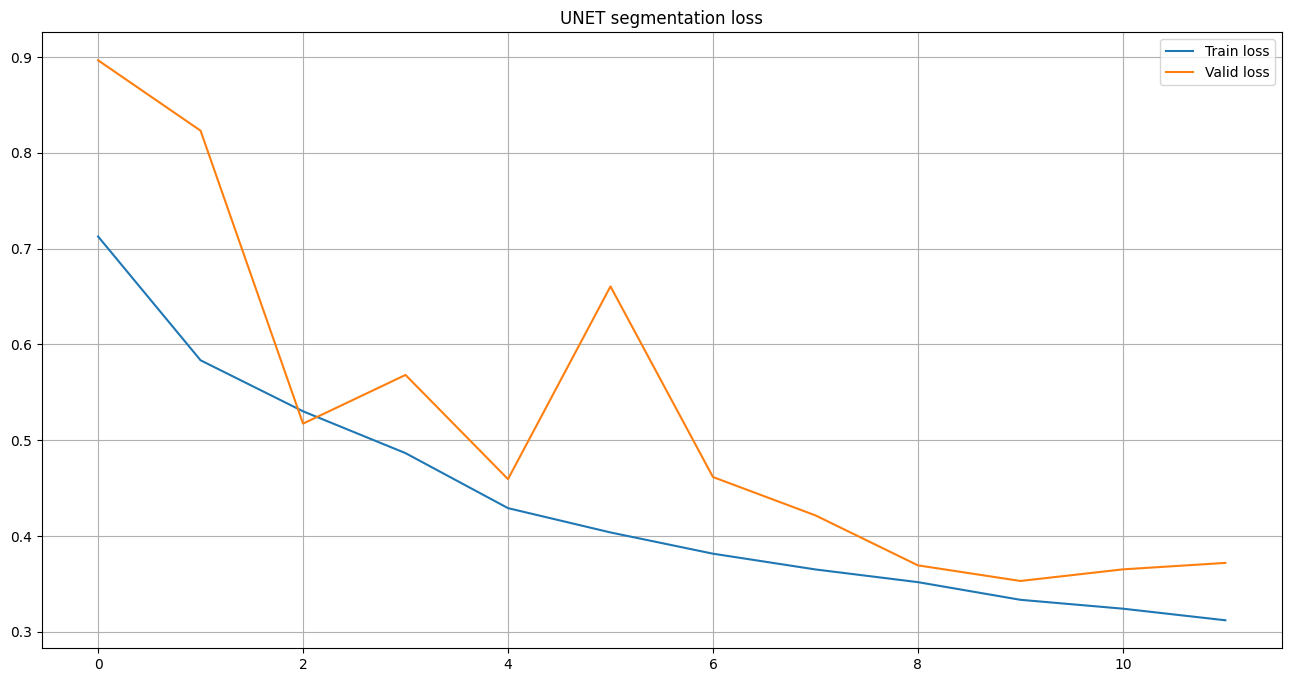

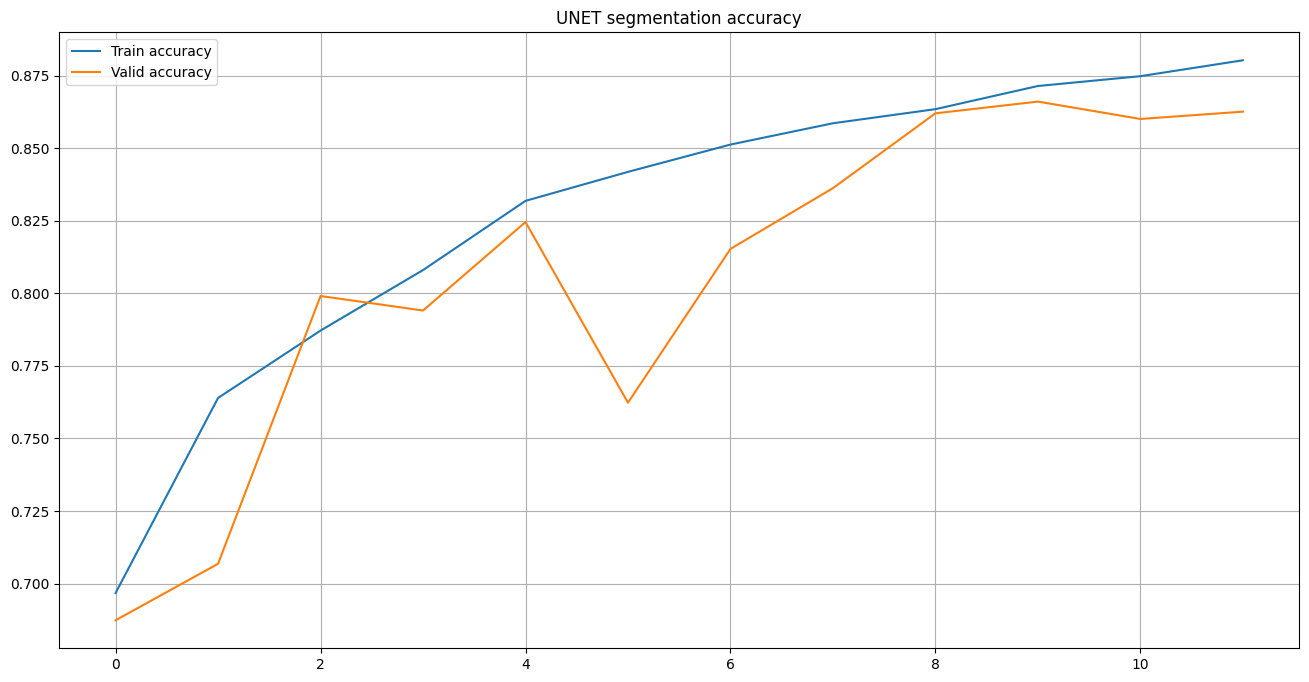

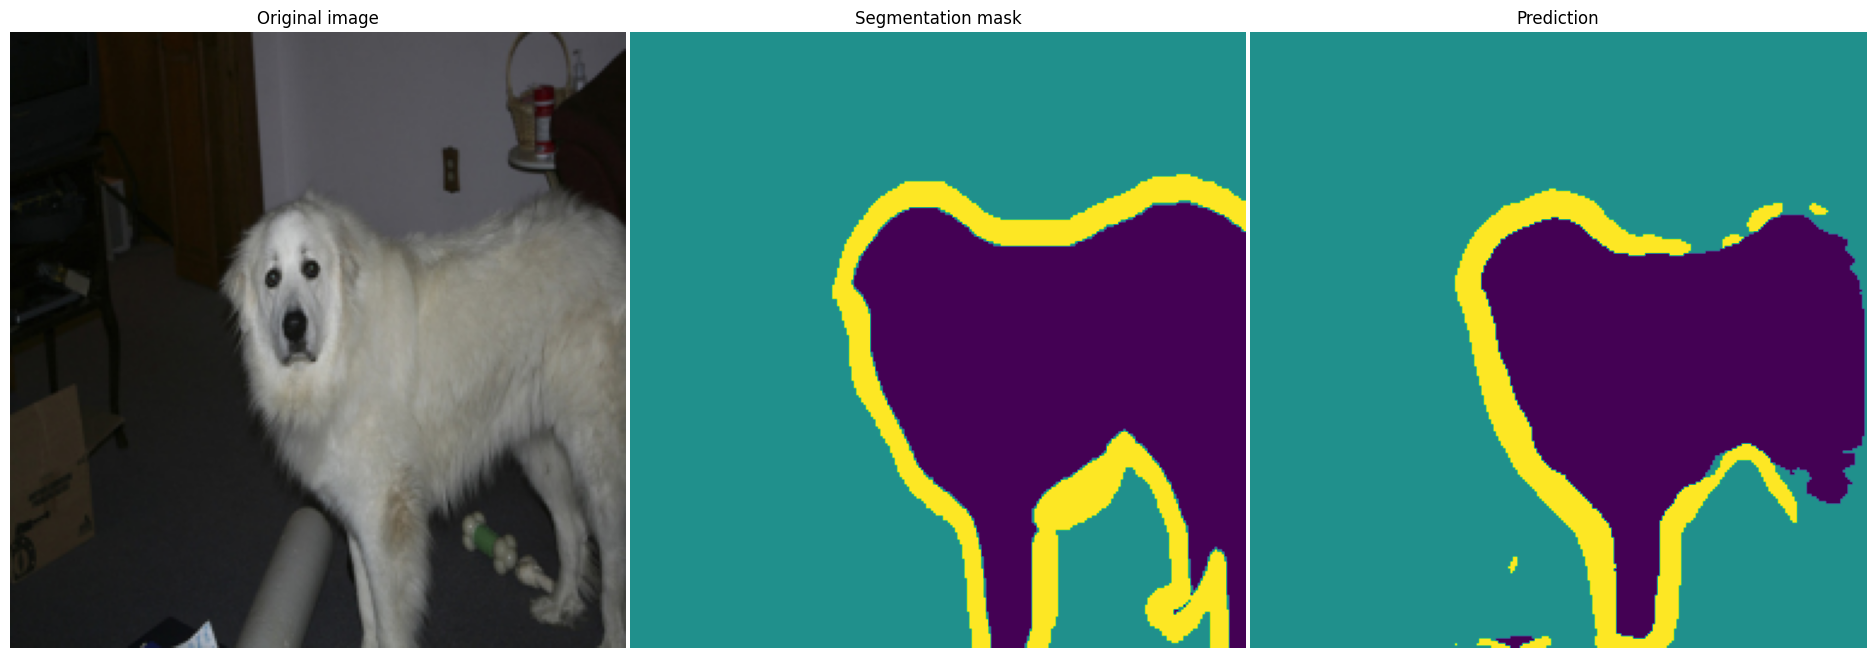

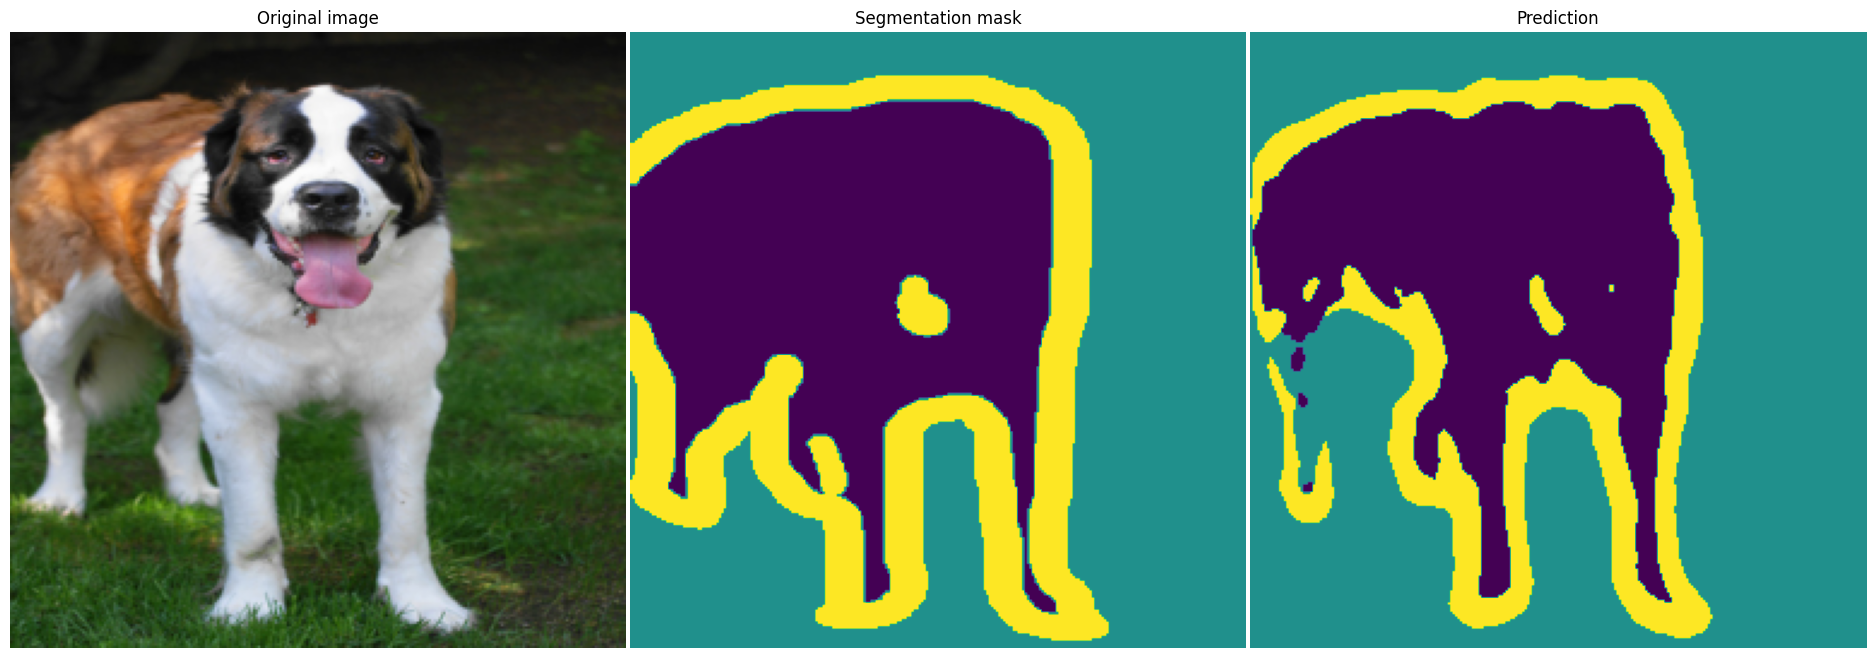

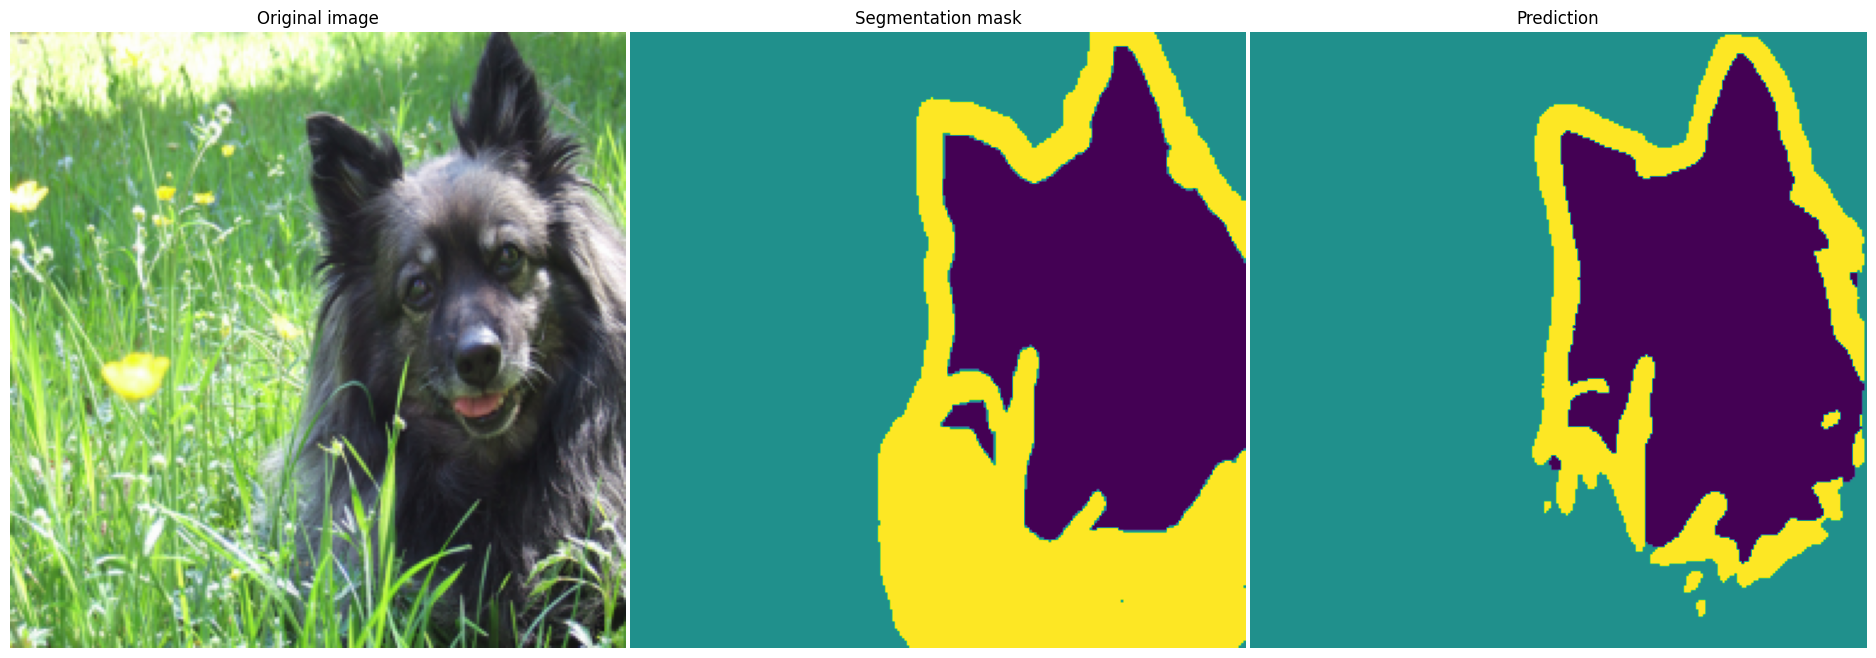

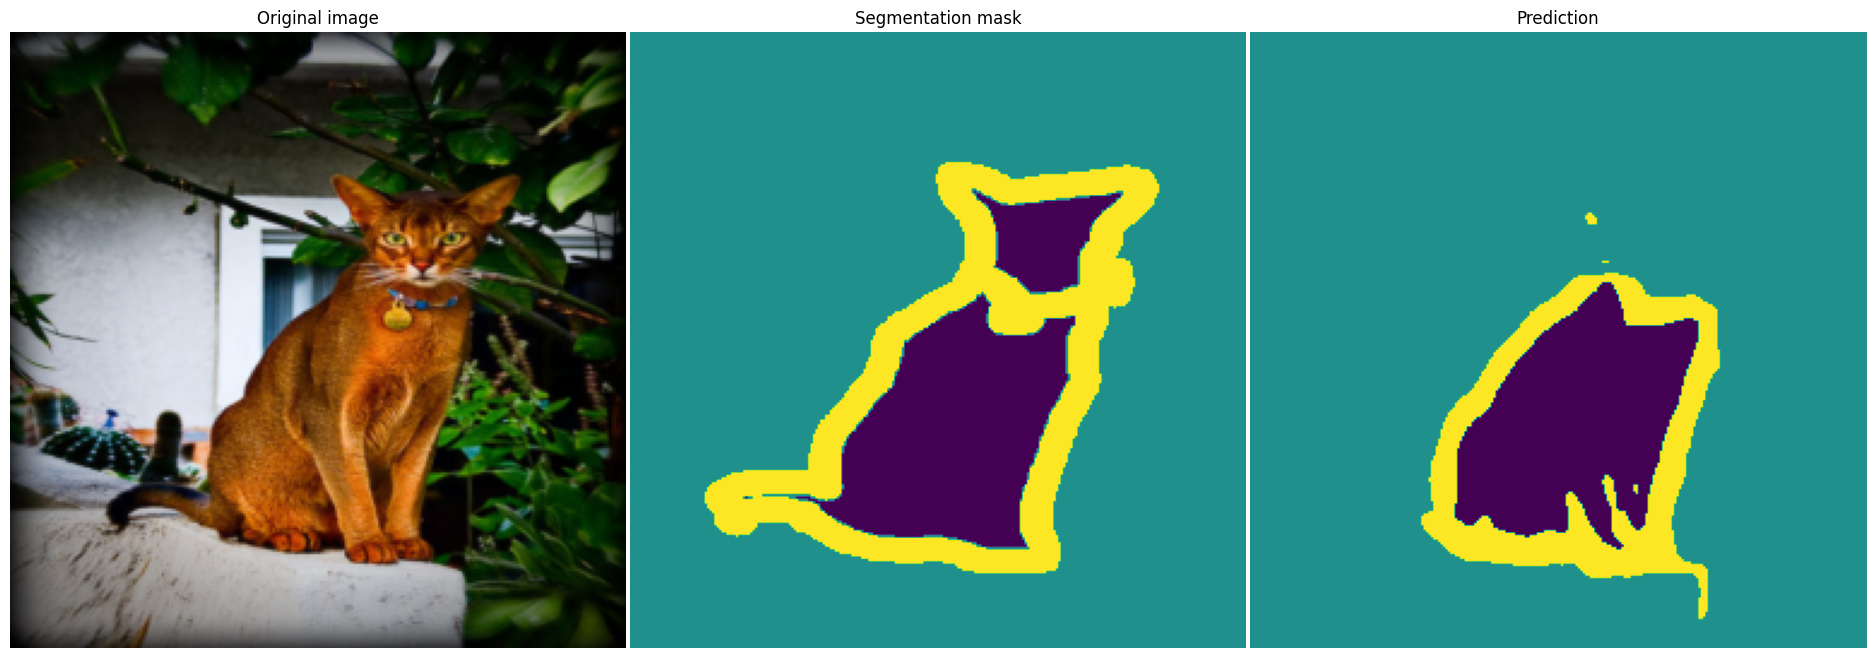

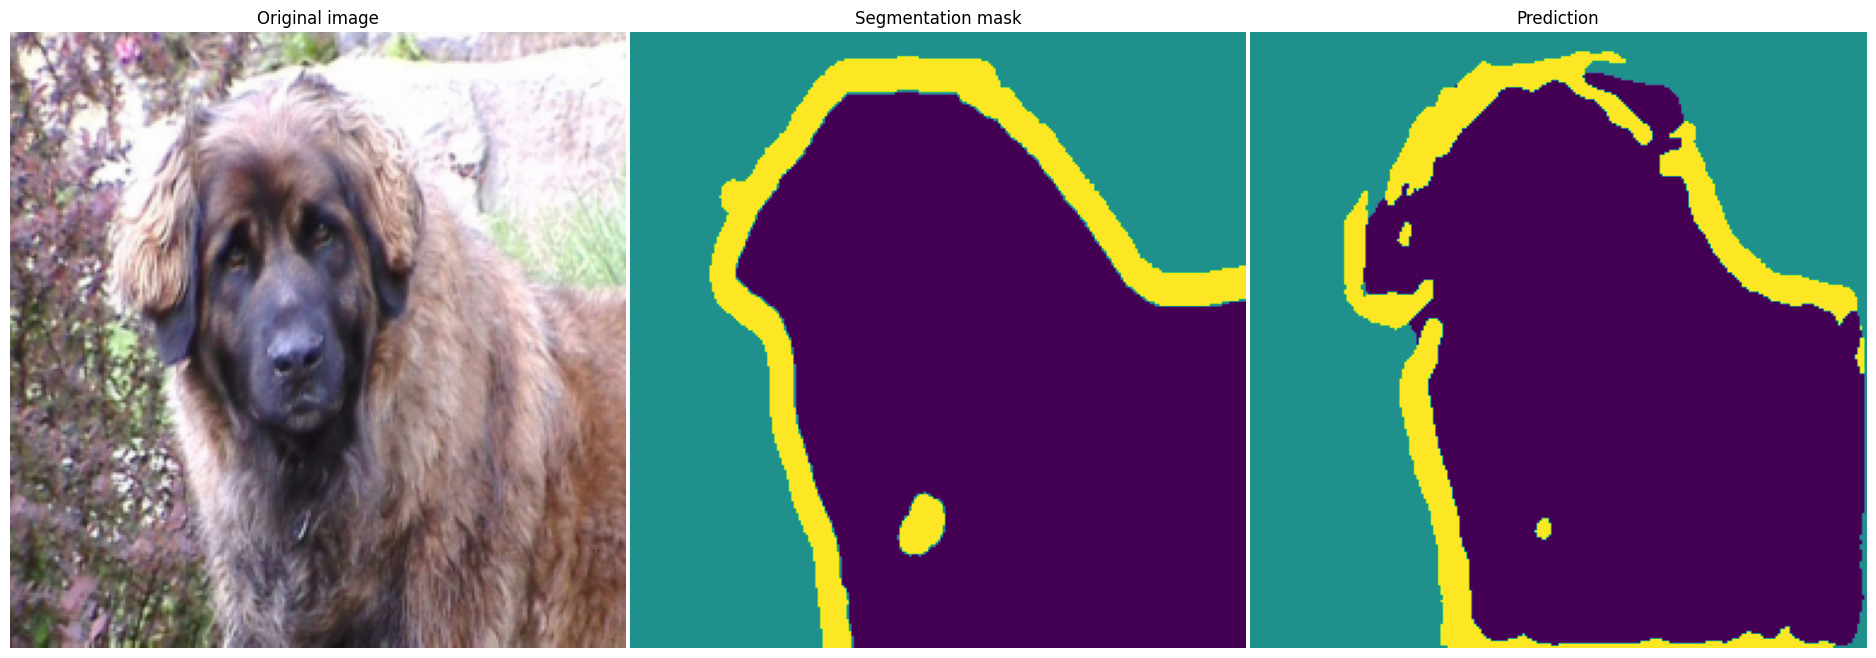

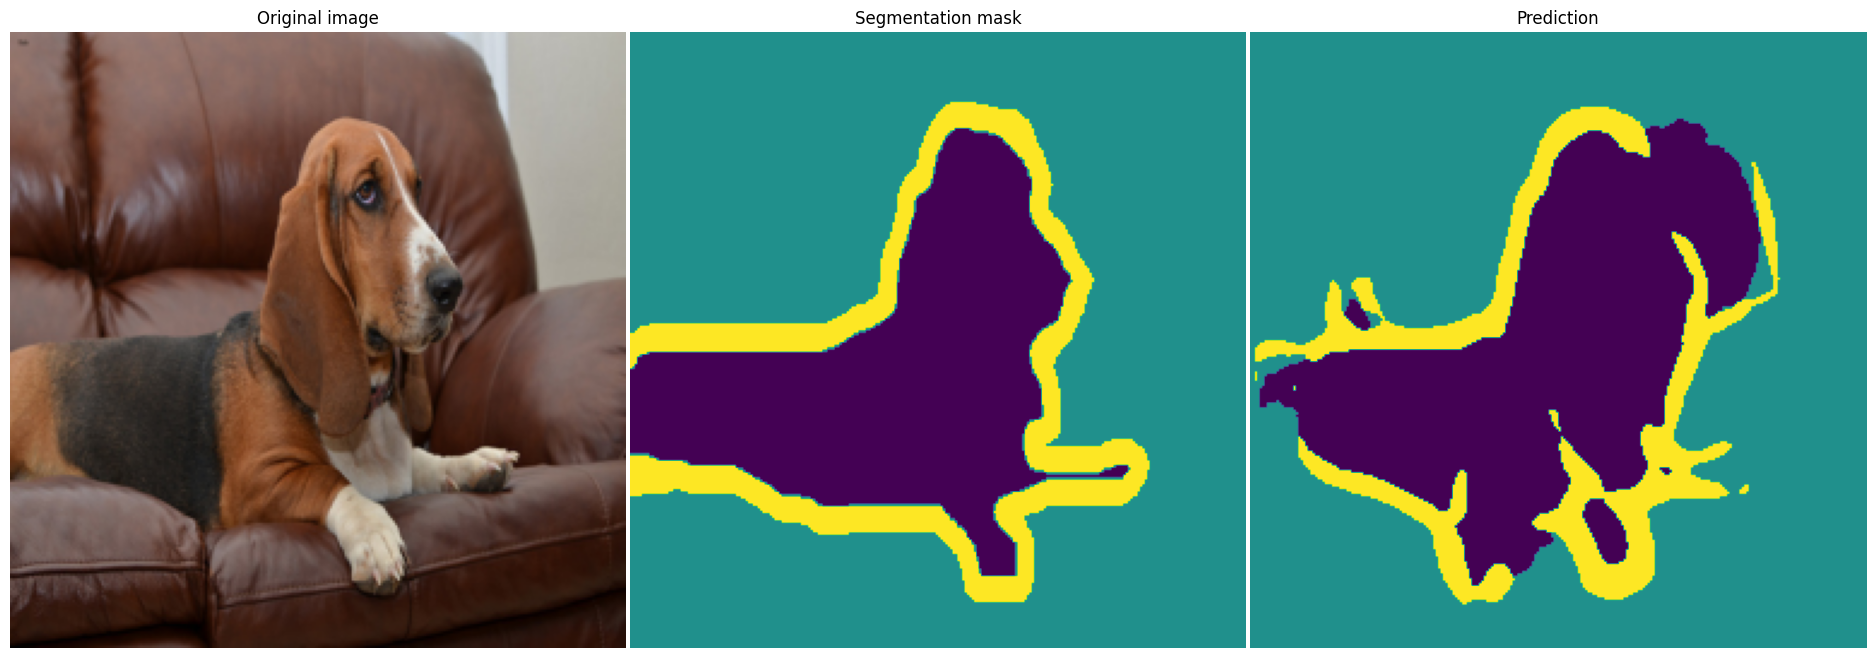

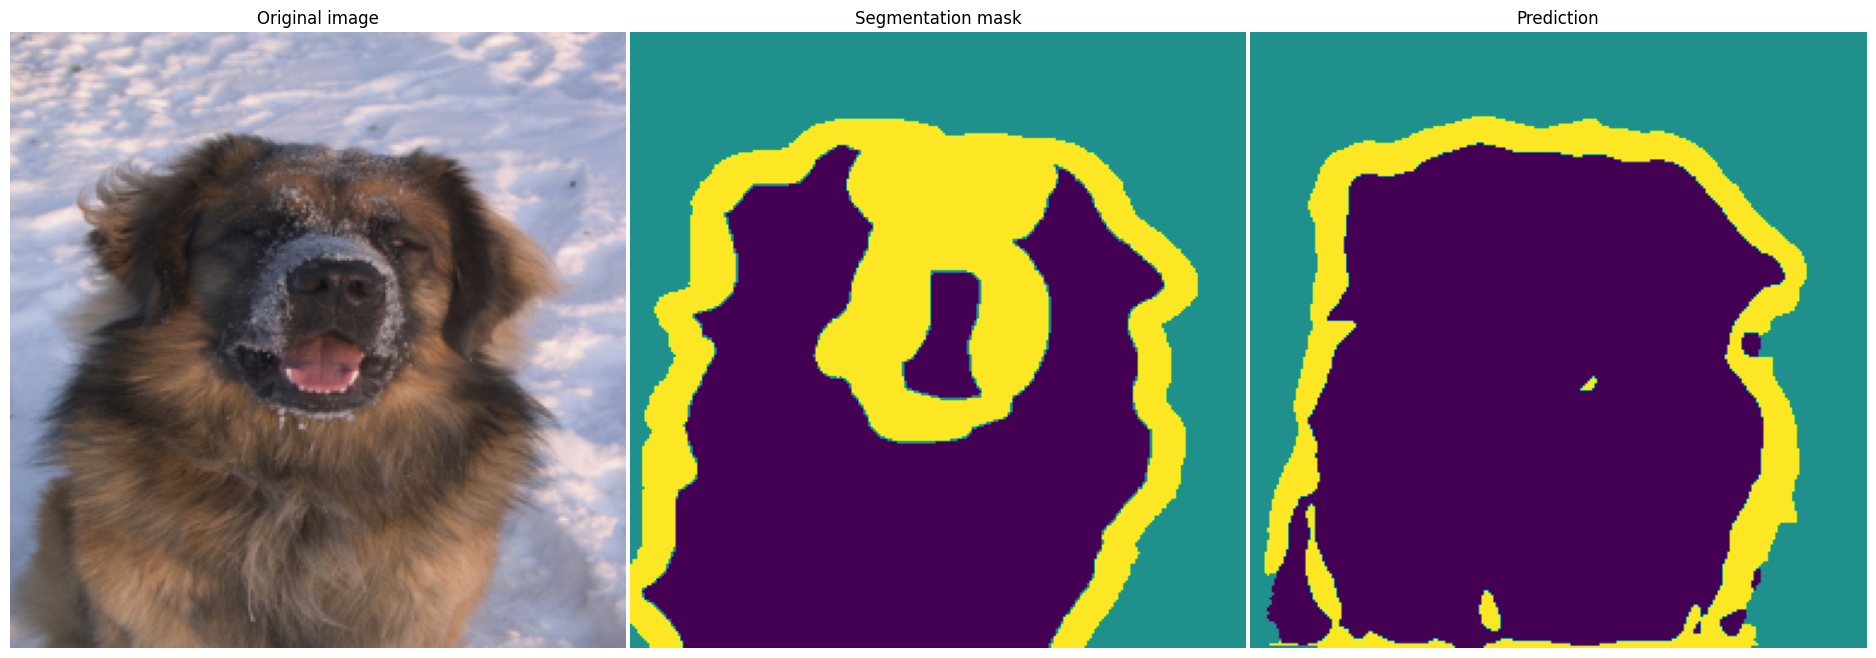

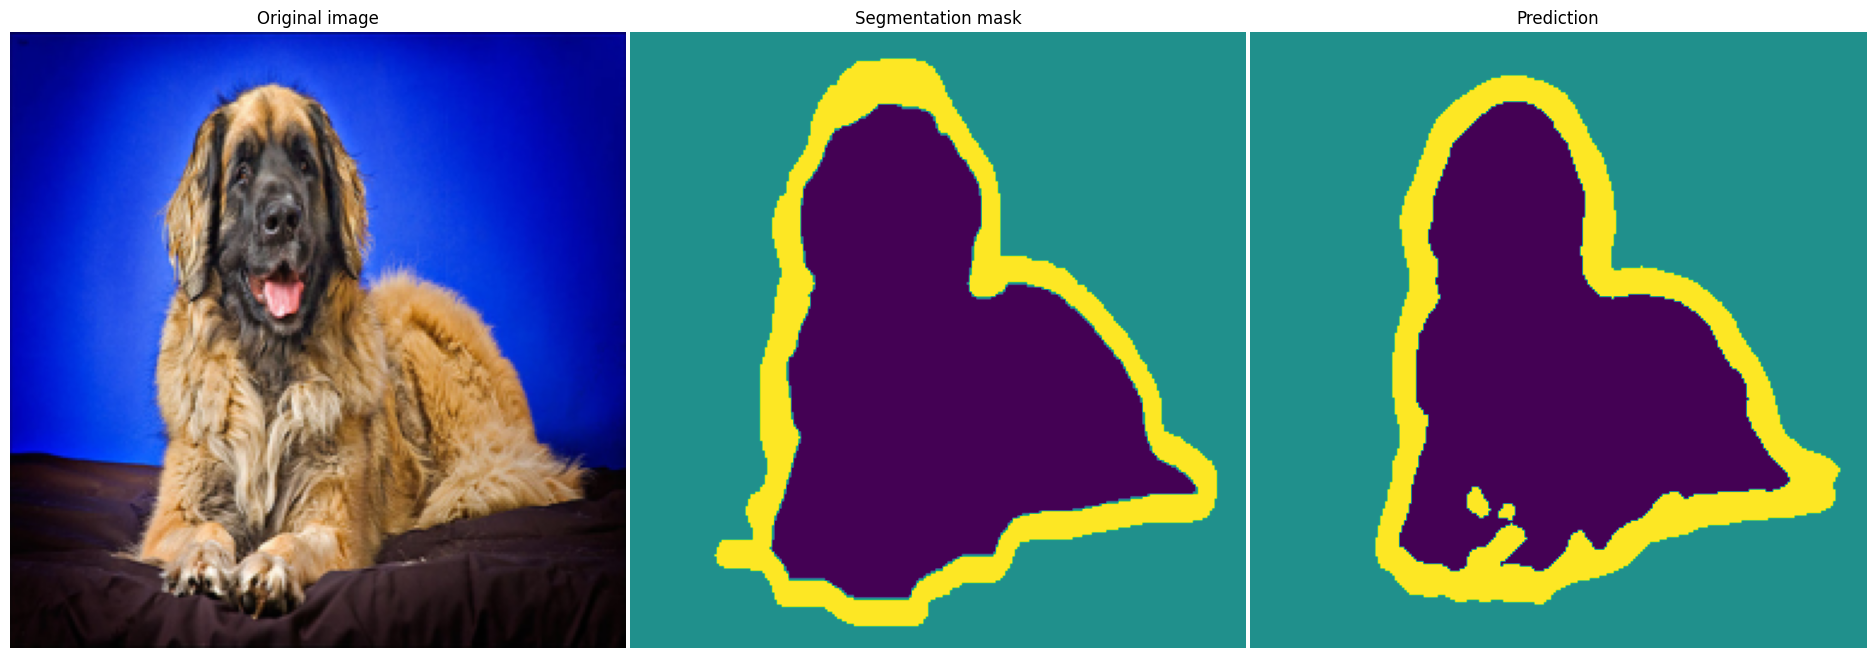

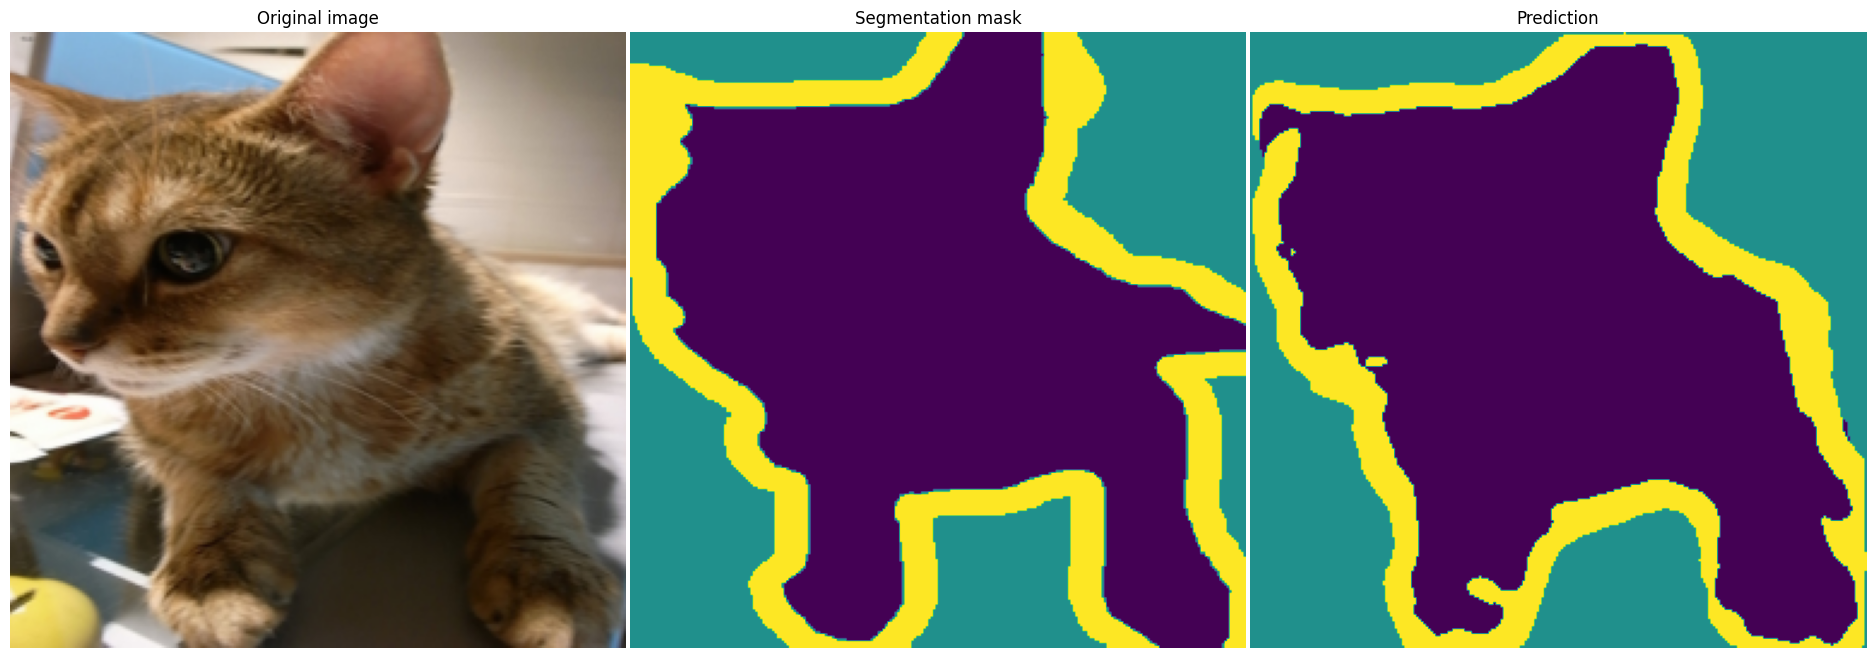

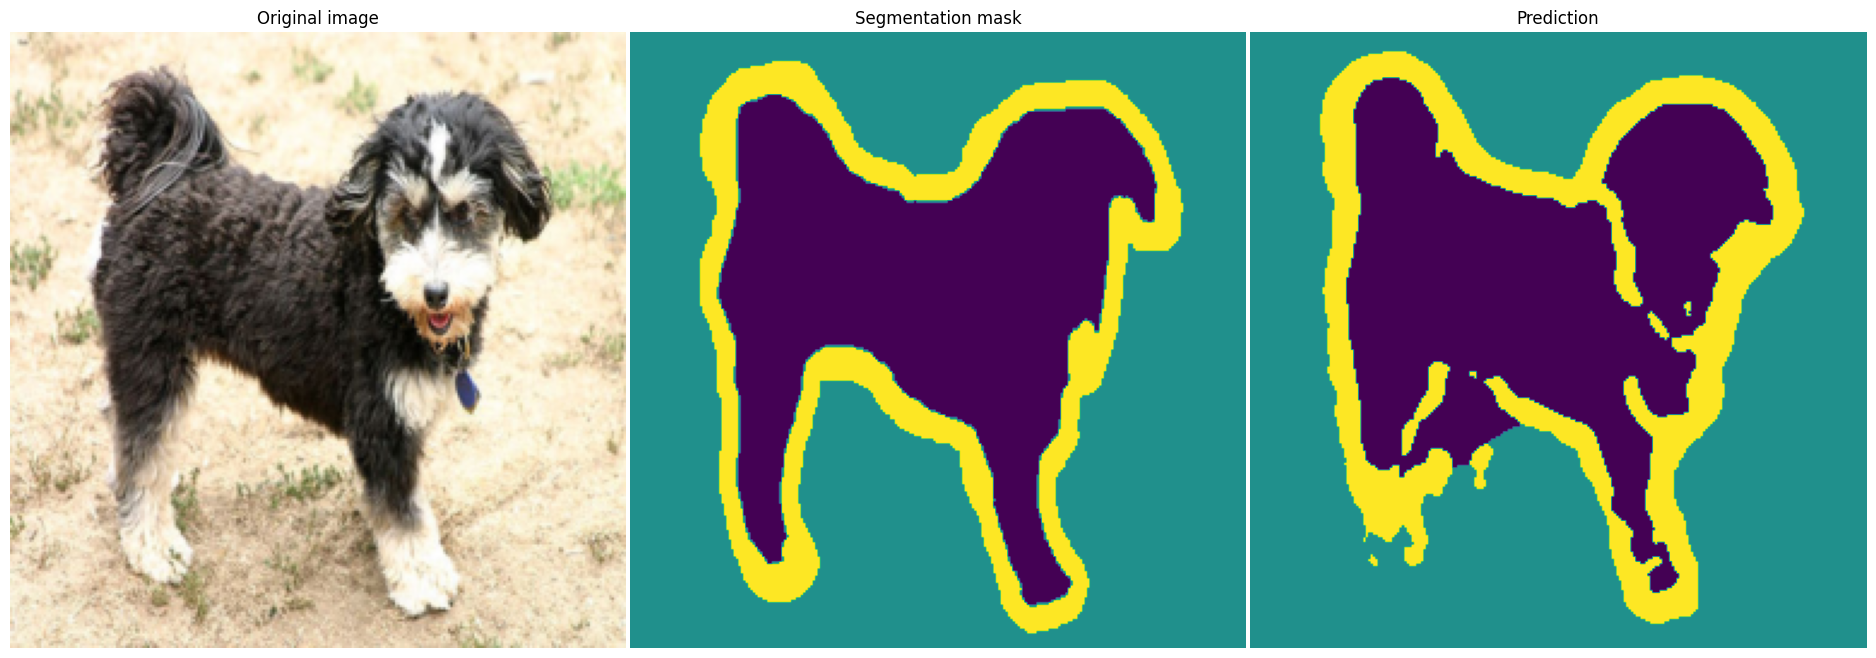

Total training and evaluation time 2378.2
accuracy =  0.8625617218017578


UNet(
  (down_layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
  )
  (down_layer_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
  )
  (down_layer_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

In [17]:
whole_train_valid_cycle(model, 12, 'UNET segmentation')

In [18]:
@torch.inference_mode()
def predict_segmentation(model: nn.Module, loader: DataLoader, device: torch.device):
    model.eval()
    prediction = []
    for x, _ in loader:
        output = model(x.to(device)).cpu()
        prediction.append(torch.argmax(output, dim=1))
    prediction = torch.cat(prediction)
    return prediction

Делаем тензор с предсказаниями (размер [200, 1, 256, 256])

In [19]:
pred = predict_segmentation(model, valid_loader, device).reshape([200, 1, 256, 256])

In [20]:
pred = pred.to(torch.uint8)

Сохраняем предсказания обученной модели

In [21]:
# # Specify a path
# PATH = "UNET_model.pt"

# # Save
# torch.save(pred, PATH)